### Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

### Bugra Turan, 28.01.2018

In this notebook we will build a neural network that is capable of recognizing german traffic sign with a high accuracy of over 93%. For this, different techniques will be used. 

First, the data set is investigated. Secondly, we will need to preprocess the data and augment it for better performance. The augmentation of the set is complex and will include scaling, rotation, translation, contrast normalization and pixel dropout of images. The preprocessing consists of: converting to grayscale and normalization.

In a third step we will define the topology of the neural network which is basically the LeNet implementation of the Udacity course with changes as reported in the paper by provided with this project by Y LeCun. A dropout was tested in different layers of the network but its impact on the accuracy was not characterized completly.

Finally we can train the network. The parameters are chosen in a way that the required accuracy is reached.

In a last step, the pipeline is tested on new images from the internet. The results show that the implementation is accurate and stable.

---
## Step 1: Preprocessing

### Load pickled data sets

In [1]:
# Load pickled data
import pickle

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Visualization and statistics

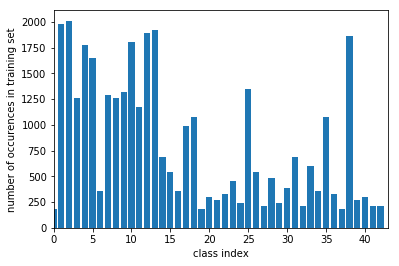

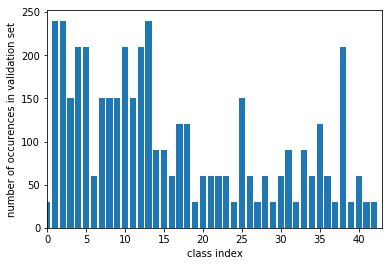

Training examples = 34799 Testing examples = 12630 Validation examples= 4410
Data shape = (32, 32, 3)
No. of classes = 43


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = np.array(X_train[0]).shape


# Statistics on the dataset.
plt.figure()
n_classes = len(set(y_train))
classes, index, counts = np.unique(y_train, return_index = True, return_counts = True)
plt.bar(np.arange(n_classes), counts)
plt.xlabel('class index')
plt.ylabel('number of occurences in training set')
plt.xlim([0, n_classes])
plt.show()
    
plt.figure()
n_classes = len(set(y_valid))
classes, index, counts = np.unique(y_valid, return_index = True, return_counts = True)
plt.bar(np.arange(n_classes), counts)
plt.xlabel('class index')
plt.ylabel('number of occurences in validation set')
plt.xlim([0, n_classes])
plt.show()

print("Training examples =", n_train, "Testing examples =", n_test, "Validation examples=",n_validation)
print("Data shape =", image_shape)
print("No. of classes =", n_classes)

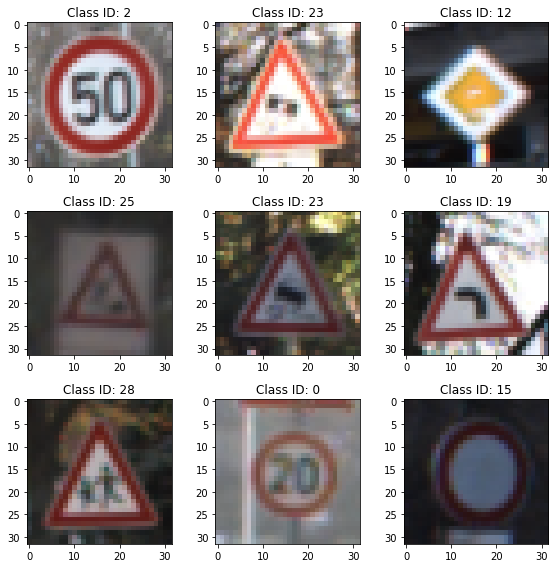

In [3]:
import random

def draw_random_set(X_train, y_train):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    fig, ax = plt.subplots(3, 3, figsize=(8,8))
    for i in range(0,3):
        for j in range(0,3):
            ax[i,j].imshow(image, cmap="gray")
            ax[i,j].set_title("Class ID: "+ str(y_train[index]))
            index = random.randint(0, len(X_train))
            image = X_train[index].squeeze()
    fig.tight_layout()
    plt.show()

# Draw a random set of the as-is training set
draw_random_set(X_train, y_train)

### Pre-process the Data Set (normalization, grayscale, augmentation etc.)

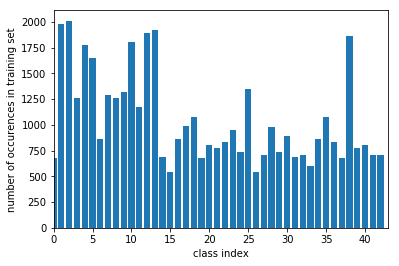

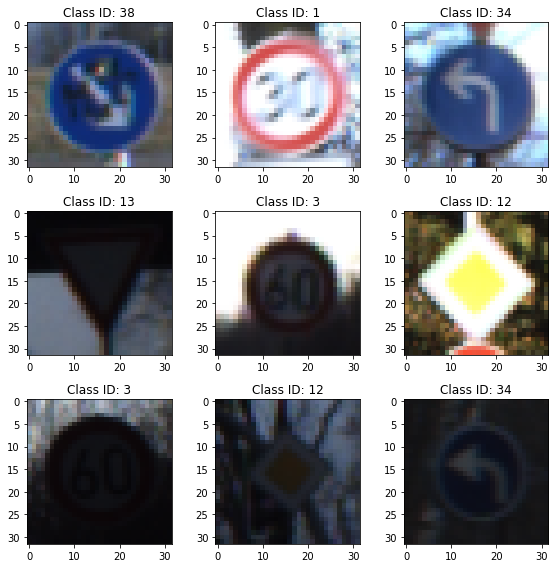

In [4]:
from imgaug import augmenters as iaa
import imgaug as ia
import cv2

def seq_augment(data):
    # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
    sometimes = lambda aug: iaa.Sometimes(1, aug)
    seq = iaa.Sequential([
        sometimes(iaa.Affine(
                scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-15, 15))), # rotate by -45 to +45 degrees
        sometimes(iaa.Multiply((1, 1.1))),
        sometimes(iaa.ContrastNormalization((1.25, 1.5))),
        sometimes(iaa.Dropout(p=(0.01, 0.05)))
            ])
    return seq.augment_images(data)

#############################################Own augmentation pipeline###############################

def img_per_class_augment(n_missing, X_train, y_train):
    X_train_aug = []
    y_train_aug = []

    for j in range(n_missing):
        i=np.random.randint(0,X_train.shape[0])
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
        
    ###augment image set
    X_train_aug=seq_augment(X_train_aug)
    
    ###concatenate the training data  
    X_train_aug = np.array(X_train_aug)
    y_train_aug = np.array(y_train_aug)
    X_train = np.concatenate((X_train, X_train_aug), axis=0)
    y_train = np.concatenate((y_train, y_train_aug), axis=0)

    return X_train, y_train

#Tested class-dependent image augmentation for classes that 
#have less than 500 samples. However, the overall accuracy decreases.
for loop in range(0,100):
    for class_n in range(n_classes):
        class_indices = np.where(y_train == class_n)
        n_samples = len(y_train[class_indices[0]])
        if n_samples < 500:
            n_missing = 500-n_samples
            X_train_classes, y_train_classes = img_per_class_augment(n_missing, X_train[class_indices[0]], y_train[class_indices[0]])
            X_train = np.concatenate((X_train, X_train_classes), axis=0)
            y_train = np.concatenate((y_train, y_train_classes), axis=0)
            
plt.figure()
n_classes = len(set(y_train))
classes, index, counts = np.unique(y_train, return_index = True, return_counts = True)
plt.bar(np.arange(n_classes), counts)
plt.xlabel('class index')
plt.ylabel('number of occurences in training set')
plt.xlim([0, n_classes])
plt.show()

# Draw a random set of the augmented, normalized, grayscale training set
draw_random_set(X_train, y_train)

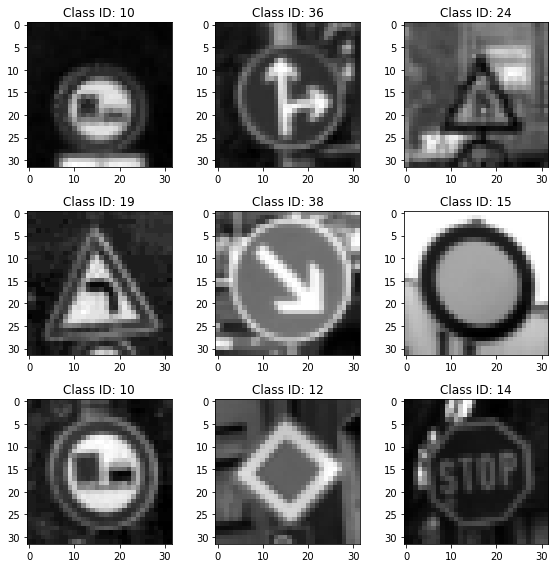

In [5]:
def normalize_and_grayscale_data(X):
    ###normalization
    X = (X - 128.) / 128.
    ###convert to grayscale
    X = np.sum(X/3, axis=3, keepdims=True)
    return X

#pre-process training set
X_train = normalize_and_grayscale_data(X_train)

#pre-process validation set
X_valid = normalize_and_grayscale_data(X_valid)

#pre-process test set
X_test = normalize_and_grayscale_data(X_test)

# Draw a random set of the augmented, normalized, grayscale training set
draw_random_set(X_train, y_train)

# Step 2: Model Architecture

In [6]:
import tensorflow as tf

EPOCHS = 60
BATCH_SIZE = 128

# Dropout was introduced at different layer depth but did not lead to good results...
# Using dropout in the augmentation gives less reduction in the accuracy.
keep_prob1 = 1 
keep_prob2 = 0.9
keep_prob3 = 0.8
keep_prob4 = 0.6

### Network Topology

In [7]:
from tensorflow.contrib.layers import flatten

def LeCunNet(x,train=True):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    ###############################################################################################
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    weight1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1 = tf.nn.conv2d(x, weight1, strides=[1, 1, 1, 1], padding='VALID')
    bias1 = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.bias_add(conv1, bias1)
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    output_layer1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Dropout
    if(train):
        output_layer1 = tf.nn.dropout(output_layer1, keep_prob1)
    
    ###############################################################################################
    # Layer 2: Convolutional. Output = 10x10x16.
    weight2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2 = tf.nn.conv2d(output_layer1, weight2, strides=[1, 1, 1, 1], padding='VALID')
    bias2 = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.bias_add(conv2, bias2)          
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    output_layer2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Dropout
    if(train):
        output_layer2 = tf.nn.dropout(output_layer2, keep_prob2)
    
    ###############################################################################################
    # Layer 3: Convolutional. Output = 1x1x400.
    weight3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma))
    conv3 = tf.nn.conv2d(output_layer2, weight3, strides=[1, 1, 1, 1], padding='VALID')
    bias3 = tf.Variable(tf.zeros(400))
    conv3 = tf.nn.bias_add(conv3, bias3)   
    # Activation.
    output_layer3 = tf.nn.relu(conv3)
    # Dropout
    if(train):
         output_layer3 = tf.nn.dropout(output_layer3, keep_prob3)
    
    ###############################################################################################
    # Flatten output_layer2. Input = 5x5x16. Output = 400.
    output_layer2_flat = flatten(output_layer2)
    # Flatten output_layer3. Input = 1x1x400. Output = 400.
    output_layer3_flat = flatten(output_layer3)
    # Concat output_layer2_flat and output_layer3_flat. Input = 400 + 400. Output = 800
    concat1 = tf.concat_v2([output_layer3_flat, output_layer2_flat], 1)
    # Dropout
    if(train):
        concat1 = tf.nn.dropout(concat1, keep_prob4)
    
    ###############################################################################################
    # Layer 4: Fully Connected. Input = 800. Output = 43.
    weight4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma))
    bias4 = tf.Variable(tf.zeros(43))    
    logits = tf.add(tf.matmul(concat1, weight4), bias4)
    
    return logits

In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

In [9]:
from sklearn.utils import shuffle

# Use variable learning rate does not seem to have a big impact
#global_step = tf.Variable(0, trainable=False)
#starter_learning_rate = 0.001
#learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100000, 0.6, staircase=True)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#training_operation = optimizer.minimize(loss_operation, global_step=global_step)

logits = LeCunNet(x)
#logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
session = tf.Session()
session.run(tf.global_variables_initializer())

def evaluate(X_data, y_data):
    total_samples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, total_samples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / total_samples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_samples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        
        #Shuffle data set in every epoch
        X_train, y_train = shuffle(X_train, y_train)
        
        #Sweep batches
        for offset in range(0, total_samples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            #Train batch
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        #Validation
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.729

EPOCH 2 ...
Validation Accuracy = 0.833

EPOCH 3 ...
Validation Accuracy = 0.850

EPOCH 4 ...
Validation Accuracy = 0.876

EPOCH 5 ...
Validation Accuracy = 0.890

EPOCH 6 ...
Validation Accuracy = 0.890

EPOCH 7 ...
Validation Accuracy = 0.888

EPOCH 8 ...
Validation Accuracy = 0.900

EPOCH 9 ...
Validation Accuracy = 0.903

EPOCH 10 ...
Validation Accuracy = 0.898

EPOCH 11 ...
Validation Accuracy = 0.900

EPOCH 12 ...
Validation Accuracy = 0.907

EPOCH 13 ...
Validation Accuracy = 0.913

EPOCH 14 ...
Validation Accuracy = 0.910

EPOCH 15 ...
Validation Accuracy = 0.920

EPOCH 16 ...
Validation Accuracy = 0.912

EPOCH 17 ...
Validation Accuracy = 0.916

EPOCH 18 ...
Validation Accuracy = 0.922

EPOCH 19 ...
Validation Accuracy = 0.919

EPOCH 20 ...
Validation Accuracy = 0.918

EPOCH 21 ...
Validation Accuracy = 0.915

EPOCH 22 ...
Validation Accuracy = 0.915

EPOCH 23 ...
Validation Accuracy = 0.927

EPOCH 24 ...
Validation Accura

### Analyze Performance

In [11]:
with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))
    
    validation_accuracy = evaluate(X_valid, y_valid)
    print("Validation Set Accuracy = {:.3f}".format(validation_accuracy))
    
    training_accuracy = evaluate(X_train, y_train)
    print("Train Set Accuracy = {:.3f}".format(training_accuracy))

Test Set Accuracy = 0.931
Validation Set Accuracy = 0.939
Train Set Accuracy = 0.992


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

Image 1 top 5 are:
 Class ID: 11 100.00% Class ID: 30 0.00% Class ID: 27 0.00% Class ID: 21 0.00%.


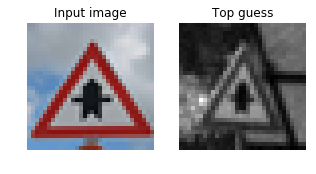

Image 2 top 5 are:
 Class ID: 0 100.00% Class ID: 1 0.00% Class ID: 5 0.00% Class ID: 6 0.00%.


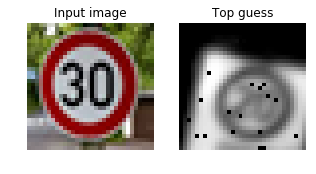

Image 3 top 5 are:
 Class ID: 12 100.00% Class ID: 40 0.00% Class ID: 9 0.00% Class ID: 35 0.00%.


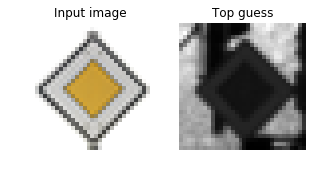

Image 4 top 5 are:
 Class ID: 38 100.00% Class ID: 34 0.00% Class ID: 29 0.00% Class ID: 0 0.00%.


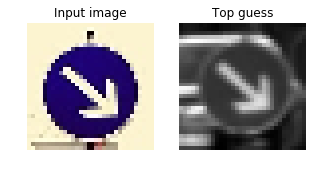

Image 5 top 5 are:
 Class ID: 34 100.00% Class ID: 38 0.00% Class ID: 30 0.00% Class ID: 21 0.00%.


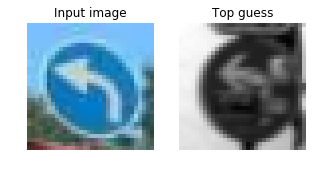

Image 6 top 5 are:
 Class ID: 18 100.00% Class ID: 26 0.00% Class ID: 24 0.00% Class ID: 27 0.00%.


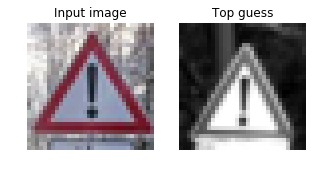

Image 7 top 5 are:
 Class ID: 25 98.17% Class ID: 24 1.81% Class ID: 22 0.02% Class ID: 29 0.00%.


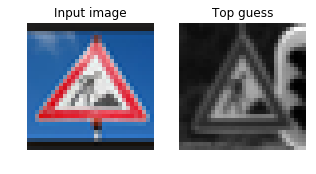

Image 8 top 5 are:
 Class ID: 3 99.99% Class ID: 11 0.01% Class ID: 0 0.00% Class ID: 31 0.00%.


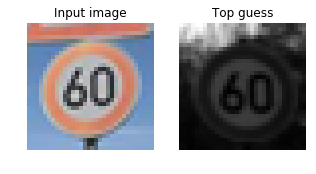

Test Set Accuracy = 0.750


In [12]:
# Load images from .png files to `X_custom` NumPy array
from skimage import io
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

# Read new test images
X_custom = np.empty([0, 32, 32, 3], dtype ='uint8')
for i in range(8):
    raw_path = "examples/"
    image = io.imread(raw_path + "{}".format(i + 1) + '.png')
    X_custom = np.append(X_custom, [image[:, :, :3]], axis = 0)

test_images=X_custom

y_pred = np.array([11, 1, 12, 38, 34, 18, 25, 3])
X_pred = normalize_and_grayscale_data(X_custom)


softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)

with tf.Session() as sess:
    saver3 = tf.train.import_meta_graph('./lenet.meta')
    saver3.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: X_pred, y: y_pred})
    my_top_k = sess.run(top_k, feed_dict={x: X_pred, y: y_pred})
    
    for i in range(0,len(my_top_k[0])):
        
        ###Print###
        print("Image "+str(i+1)+" top 5 are:")
        for j in range(0,4):
            print(" Class ID: {}".format(my_top_k[1][i][j])+" {:.2f}".format(100*my_top_k[0][i][j])+"%", end="")
        print(".")
        
        ###Images###
        index = np.argwhere(y_train == my_top_k[1][i][0])[0]
        top_guess = X_train[index].squeeze()
        input_image = X_custom[i].squeeze()
        
        
        #plt.figure()
        fig, ax = plt.subplots(1,2, figsize=(5, 5))
        ax = ax.ravel()
        ax[0].axis('off')
        ax[0].set_title("Input image")
        ax[0].imshow(input_image)
        
        ax[1].axis('off')
        ax[1].set_title("Top guess")
        ax[1].imshow(top_guess, cmap="gray")
        
        plt.show()
        
    test_accuracy = evaluate(X_pred, y_pred)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))